In [1]:
#Packages
import collections
import math
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageColor
import numpy as np 
from scipy.stats import norm
from scipy import ndimage
import json
import pandas as pd
import os

In [2]:
#Defining functions of hexogonal grid
Point = collections.namedtuple("Point", ["x", "y"])
_Hex = collections.namedtuple("Hex", ["q", "r", "s"])

def Hex(q, r, s): #creates the hexagon datatype 
    assert not (round(q + r + s) != 0), "q + r + s must be 0"
    return _Hex(q, r, s)

# Datatypes for pointy top or flattop lattices
Orientation = collections.namedtuple("Orientation", ["f0", "f1", "f2", "f3", "b0", "b1", "b2", "b3", "start_angle"])
Layout = collections.namedtuple("Layout", ["orientation", "size", "origin"])
layout_pointy = Orientation(math.sqrt(3.0), math.sqrt(3.0) / 2.0, 0.0, 3.0 / 2.0, math.sqrt(3.0) / 3.0, -1.0 / 3.0, 0.0, 2.0 / 3.0, 0.5)
layout_flat = Orientation(3.0 / 2.0, 0.0, math.sqrt(3.0) / 2.0, math.sqrt(3.0), 2.0 / 3.0, 0.0, -1.0 / 3.0, math.sqrt(3.0) / 3.0, 0.0)

#Functions for locating points in xy coordinates
def hex_to_pixel(layout, h): #returns the x,y coordinate of the center of the hexagon
    M = layout.orientation
    x = (M.f0*h.q+M.f1*h.r)*layout.size[0]
    y = (M.f2*h.q+M.f3*h.r)*layout.size[1]
    return Point(x + layout.origin[0] , y + layout.origin[1])

def hex_corner_offset(layout, corner): #Returns how far off each corner is from the center point
    M = layout.orientation
    size = layout.size
    angle = 2.0 * math.pi * (M.start_angle - corner) / 6.0
    return Point(size[0] * math.cos(angle), size[1] * math.sin(angle))

def polygon_corners(layout, h): #Creates an array of corners by applying the corner offset method to the center six times
    corners = []
    center = hex_to_pixel(layout, h)
    for i in range(0, 2):
        offset = hex_corner_offset(layout, i)
        corners.append(Point(center.x + offset.x, center.y + offset.y))
    return corners

def to_array(corners): # turns corners into an array of arrays for coordinates
    array_corners=[]
    for p in corners:
        array_corners.append([p.x,p.y])
    return array_corners

# Creates rectangular map of hexagons for flat top, origin is in top left
def rect_map(map_height,map_width):
    map=[]
    for q in range(map_height):
        q_offset=math.floor(q/2)
        for r in range(-q_offset,map_width-q_offset):
            #map.append(Hex(q,r-map_height//2,-(q)-(r-map_height//2)))
            map.append(Hex(q,r,-q-r))
    return map

#Gaussian function to be used globably
Gaussian= lambda x,scl,amp: amp*math.e**(-0.5*(x/scl)**2)

#Labeling methods
def distance(a,mid): #Returns the distance between two pixels
    dist_vec=np.array((mid[0]-a[0],mid[1]-a[1]))
    distance=np.linalg.norm(dist_vec)
    return distance

In [3]:
#Class for training images
class Training_im:

    image_size=[32,32]
    background_color=ImageColor.getrgb("hsl(46,0%,50%)")

    def __init__(self,bond_lengths,origin,atom_size):
        self.bl=bond_lengths
        self.o=origin
        self.atmsz=atom_size
        self.im=Image.new("RGB",self.image_size,color=self.background_color)
        self.pixel_array=np.array(self.im)
        self.blob_values_array=np.zeros((self.image_size[1],self.image_size[0]))
        self.mid=Point(self.image_size[0]//2,self.image_size[1]//2)
        self.layout=Layout(layout_flat,self.bl,self.o)
        self.make_im()
        self.neighbor_vects=[]
        self.central_atom=[]
        self.label_im()
    #Plotting methods
    def gauss_circ(self,p,radius):
        p[0]=int(p[0])
        p[1]=int(p[1])
        #radius is a given param that represents the standard deviation of the gaussian
        #plot_rad is some multiple of the radius given, it is the radius of the circle to be plotted
        _scale=radius
        plot_rad=4*radius
        color_amp=100
        color_scaling=lambda x: Gaussian(x,_scale,color_amp)
        
        for x in range(max(p[0]-plot_rad,0),min(p[0]+plot_rad,self.image_size[0])):
            y_max=math.floor(math.sqrt(plot_rad**2-(x-p[0])**2))
            for y in range(max(p[1]-y_max,0),min(p[1]+y_max,self.image_size[1])):
                dist_vec=np.array((x-p[0],y-p[1]))
                distance=np.linalg.norm(dist_vec)
                self.blob_values_array[y][x]+=color_scaling(distance)
            
    def gauss_to_color(self):
        for i in range(self.image_size[0]):
            for j in range(self.image_size[1]):
                rgbcolor=ImageColor.getrgb(f"hsl(46,{min(math.floor(self.blob_values_array[j][i]),100)}%,50%)")
                self.pixel_array[j][i][0]=rgbcolor[0]
                self.pixel_array[j][i][1]=rgbcolor[1]
                self.pixel_array[j][i][2]=rgbcolor[2]

    def plot_hex_dots(self,h,radius):
        corners=to_array(polygon_corners(self.layout,h))
        #corners.append(hex_to_pixel(layout,h)) #Drawing center dot as well. Not needed 
        for p in corners:
            self.gauss_circ(p,radius)

    #Neighbor methods
    def get_atom_locs(self,_map): # Returns an array of all the atomic locations in the map
        atom_locs=[]
        for h in _map:
            corners=to_array(polygon_corners(self.layout,h))
            for corner in corners:
                atom_locs.append(corner)
        return atom_locs
    def get_central_atom(self,atom_locs): #Returns the atom closest to the center pixel of the image
        center_atom=[]
        min_dist=self.image_size[0]
        for a in atom_locs:
            if distance(a,self.mid)<=min_dist:
                min_dist=distance(a,self.mid)
                center_atom=a
        return center_atom

    def color_central_atom(self): #Draws the central atom in white in pixel_array
        assert self.map != 'NoneType'
        atom_locs=self.get_atom_locs(self.map)
        central_atom=self.get_central_atom(atom_locs)
        for i in range(3):
            self.pixel_array[math.floor(central_atom[1])][math.floor(central_atom[0])][i]=255

    def color_neighbors(self): #Draws the nearest neighbors in red, blue, and green in pixel_array
        assert self.map != 'NoneType'
        atom_locs=self.get_atom_locs(self.map)
        central_atom=self.get_central_atom(atom_locs)
        neighbors=self.get_nearest_neighbors(atom_locs,central_atom)
        i=0
        for n in neighbors:
            self.pixel_array[math.floor(n[1])][math.floor(n[0])][i]=225
            self.pixel_array[math.floor(n[1])][math.floor(n[0])][i-1]=0
            self.pixel_array[math.floor(n[1])][math.floor(n[0])][i-2]=0
            i+=1
        
    #Nearest neightbor vectors for "right positioned" atoms. Atoms on the left have negative vectors
    def initialize_neighbor_vec(self): #Initializes the neighbor vectors based on size/bond lentgh
        self.neighborvec1=np.array([-self.bl[0],0])
        self.neighborvec2=np.array([self.bl[0]/2,math.sqrt(3)*self.bl[1]/2])
        self.neighborvec3=np.array([self.bl[0]/2,-math.sqrt(3)*self.bl[1]/2])

    def get_nearest_neighbors(self,atom_locs,central): #Returns the nearest neighbors to the central atom. 
        #Doesn't search atom locations, just spits out where the neighbors should be given central location
        neighbors=[]
        isRight=False
        left_neighbor_x=central[0]+self.neighborvec1[0]
        for a in atom_locs:
            if left_neighbor_x-1<=a[0] and left_neighbor_x+1>=a[0]:
                isRight=True
        if isRight:
            neighbors.append(np.add(self.neighborvec1,central))
            neighbors.append(np.add(self.neighborvec2,central))
            neighbors.append(np.add(self.neighborvec3,central))
        else:
            neighbors.append(np.add(-self.neighborvec1,central))
            neighbors.append(np.add(-self.neighborvec2,central))
            neighbors.append(np.add(-self.neighborvec3,central))
        return neighbors
    
    def make_im(self):
        
        self.initialize_neighbor_vec()
        mapsize_x=math.floor(self.image_size[0]/(math.sqrt(3)*self.bl[0])*2)
        mapsize_y=math.floor(self.image_size[1]/(2*self.bl[1])*2)
        self.map=rect_map(mapsize_x,mapsize_y)
        for h in self.map:
            self.plot_hex_dots(h,self.atmsz)
        self.gauss_to_color()
        self.im_fin=Image.fromarray(self.pixel_array)
   
    def color_data(self):
        self.color_central_atom()
        self.color_neighbors()
        self.im_fin=Image.fromarray(self.pixel_array)
    
    #Labels images with central atom and neighbor vectors scaled to the size of the image
    def label_im(self):
        atom_locs=self.get_atom_locs(self.map)
        central_atom=self.get_central_atom(atom_locs)
        neighbors=self.get_nearest_neighbors(atom_locs,central_atom)
        self.central_atom=[central_atom[0]/self.image_size[0],central_atom[1]/self.image_size[1]]
        for n in neighbors:
            self.neighbor_vects.append([(central_atom[0]-n[0])/self.image_size[0],(central_atom[1]-n[1])/self.image_size[1]])


(-0.5, 31.5, 31.5, -0.5)

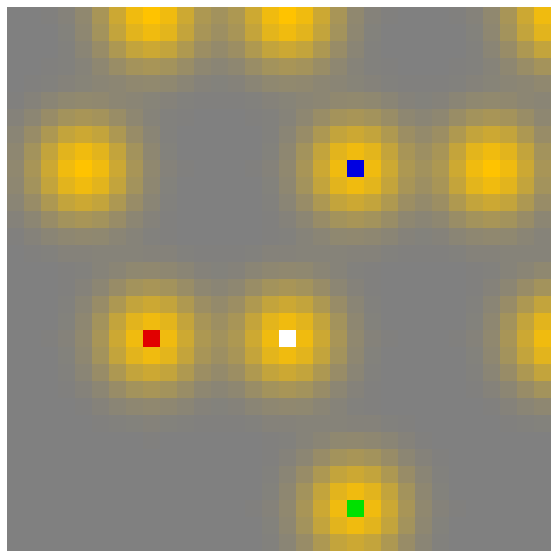

In [4]:
#Plotting images
bond_lengths=[8,math.sqrt(2)*8]
origin=[0,0]
atom_size=2
im=Training_im(bond_lengths,origin,atom_size)
im.color_data()
#print(im.central_atom)
#print(im.neighbor_vects)
fig = plt.figure(figsize = (10, 10))
ax = plt.subplot(1,1,1)
ax.imshow(im.im_fin)
ax.axis('off')

In [ ]:
#Creates training set and DataFrame with labels
train_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project\\Training_set_6_11' 

im_names=[]
central_atom_x_labels=[]
central_atom_y_labels=[]
for bl in range(6,10):
    for offset in range(0,15):
        for atom_size in range(1,3):
            im=Training_im([bl,bl],[-offset,0],atom_size)
            im_names.append(f"bl{bl}_offset{offset}_as{atom_size}.png")
            central_atom_x_labels.append(im.central_atom[0])
            central_atom_y_labels.append(im.central_atom[1])
            #im.im_fin.save(os.path.join(train_dataset_dir,f"bl{bl}_offset{offset}_as{atom_size}.png"))

data={'filename':im_names,'x_coord':central_atom_x_labels,'y_coord':central_atom_y_labels}
df=pd.DataFrame(data)
df.to_csv(os.path.join(train_dataset_dir,"training_dataframe.csv"),index=False)